In [1]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2023-07-26 13:36:21--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5jh4hpuk2gcxaaq/all.zip [following]
--2023-07-26 13:36:22--  https://www.dropbox.com/s/raw/5jh4hpuk2gcxaaq/all.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc234a0412f941ceb4acd79a9993.dl.dropboxusercontent.com/cd/0/inline/CAmAnCB1O0TOT-xa-3OPXMVtgMvlBpDeh5vk45HiKme8MP21ggtkUMzIOlG4ihM1tvIigRDjmgVV_fxxoEZIRHGo0R4JWU1i03r1cjwj-j58DkdZFm7S9AtC-O46ds1f1b04NOixRr8WFKZkMW6D6yDW/file# [following]
--2023-07-26 13:36:22--  https://uc234a0412f941ceb4acd79a9993.dl.dropboxusercontent.com/cd/0/inline/CAmAnCB1O0TOT-xa-3OPXMVtgMvlBpDeh5vk45HiKme8MP21ggtkUMzIOlG4ihM1tvIigRDjmgVV_fxxoEZIRHGo0R4JWU1i03r1cjwj-j58DkdZFm

In [6]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from imgaug import augmenters as iaa

In [7]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [8]:
# data = XO('/content/all/*')
data = XO('../data/all/*')

KeyboardInterrupt: 

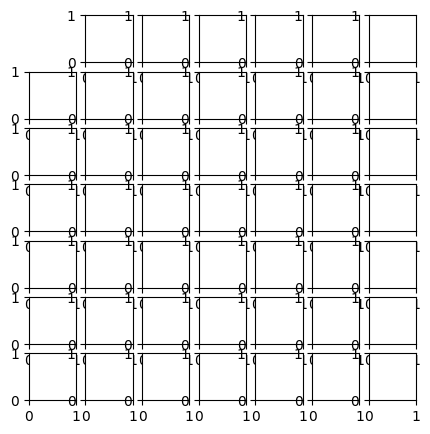

In [9]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [ ]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
trn_dl = DataLoader( XO('../data/all/*'), batch_size=32, drop_last=True)

In [ ]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
model, loss_fn, optimizer = get_model()

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0

In [ ]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

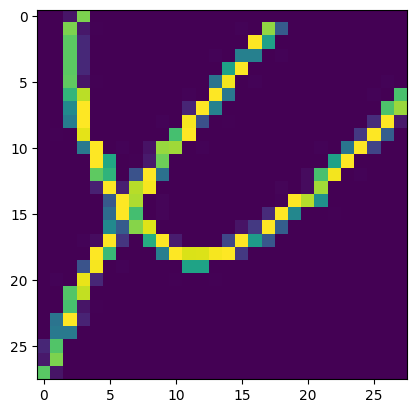

In [ ]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [ ]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

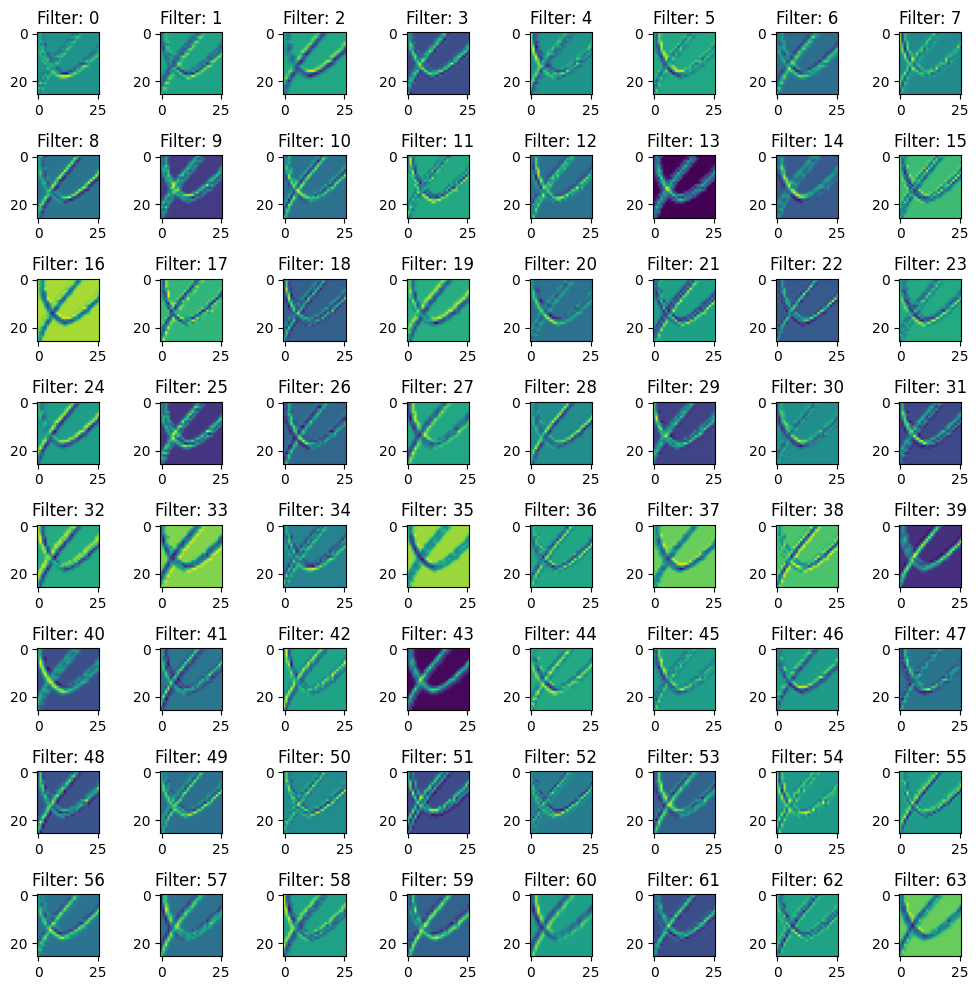

In [ ]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [ ]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [ ]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

In [ ]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

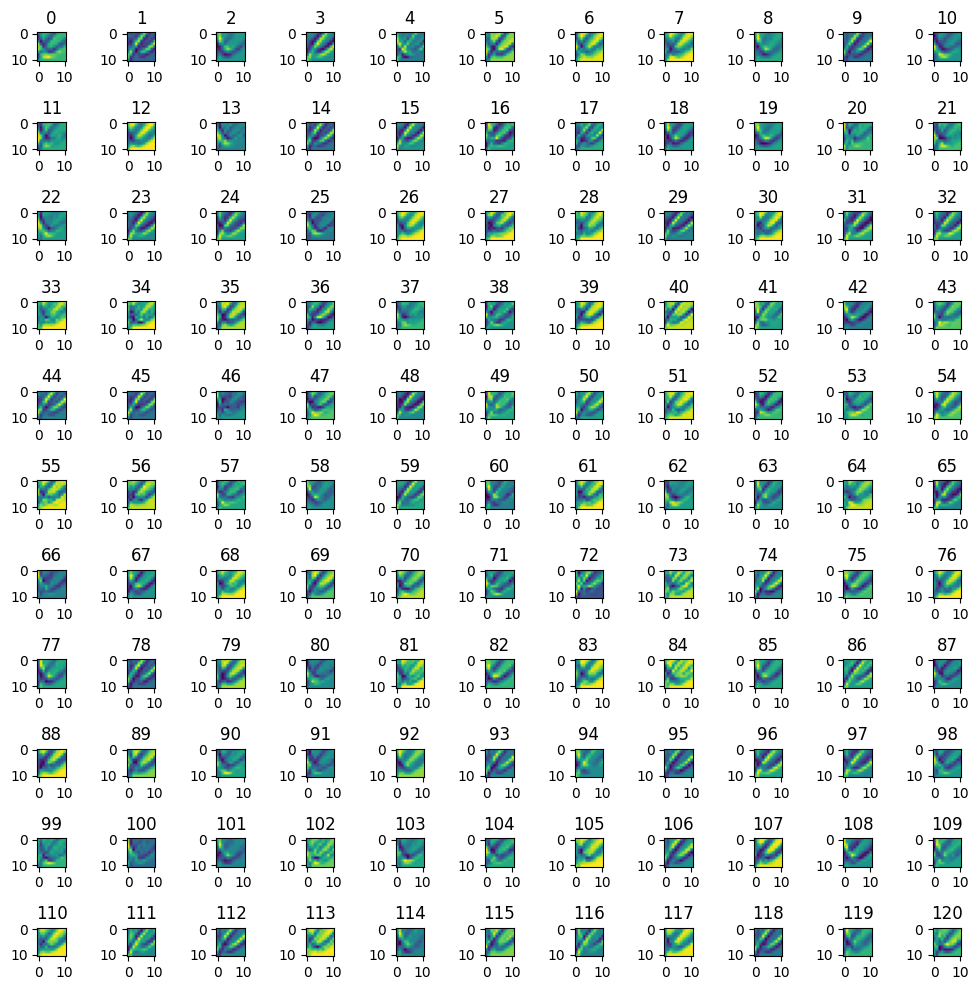

In [ ]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [ ]:
im.shape

torch.Size([1, 28, 28])

In [ ]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
len(x2)

17

In [ ]:
x2 = x2.view(-1,1,28,28)

In [ ]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

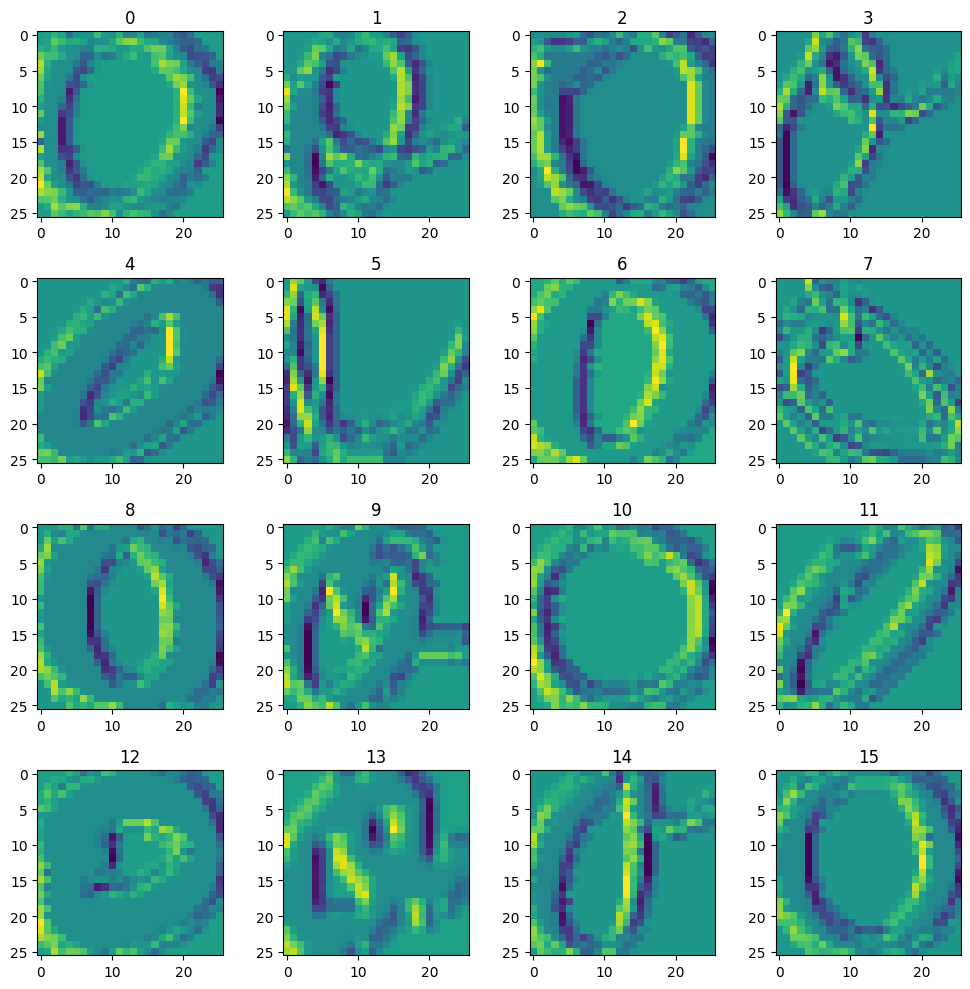

In [ ]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [ ]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [ ]:
second_intermediate_output.shape

torch.Size([17, 128, 11, 11])

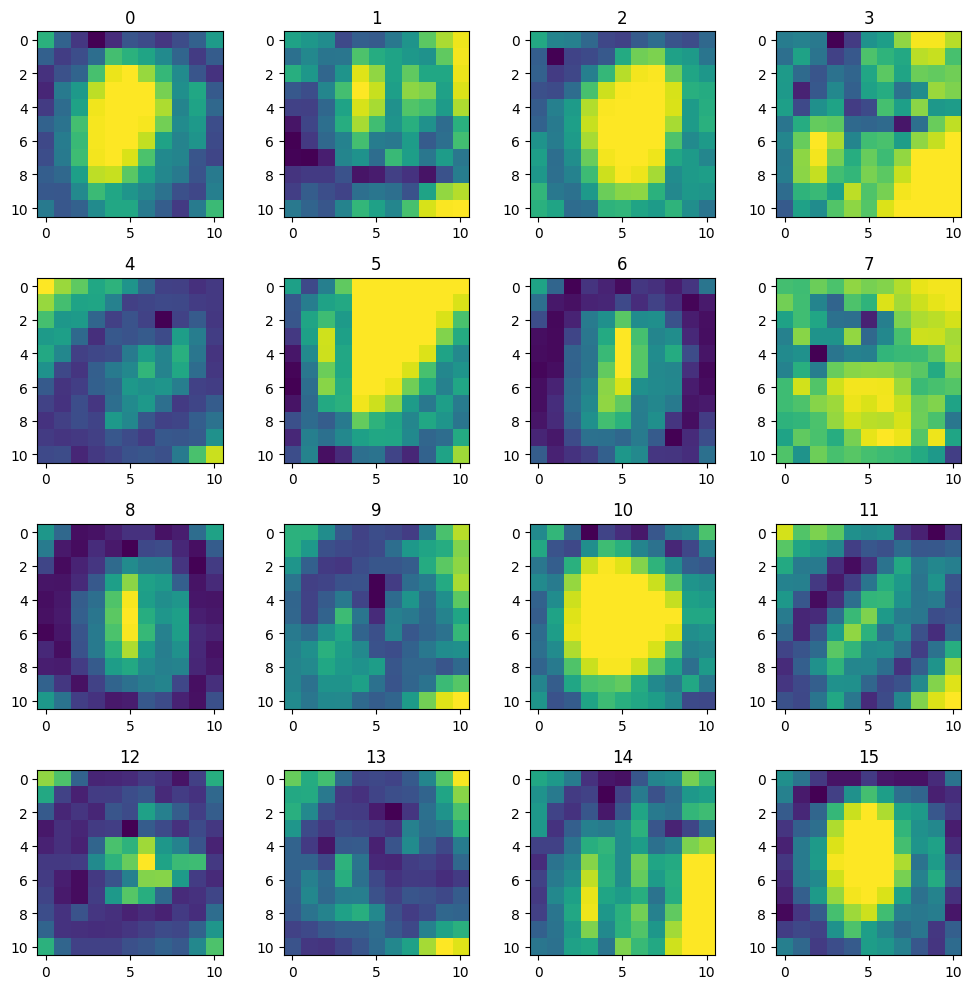

In [ ]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [ ]:
len( XO('../data/all/*'))

2498

In [ ]:
custom_dl = DataLoader(XO('../data/all/*'), batch_size=2498, drop_last=True)

SyntaxError: unmatched ')' (3416787388.py, line 1)

In [ ]:
x, y = next(iter(custom_dl))

In [ ]:
x2 = x[y==0]

In [ ]:
len(x2)

1245

In [ ]:
x2 = x2.view(len(x2),1,28,28
             )

In [ ]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

In [ ]:
flatten_layer_output.shape

torch.Size([1245, 3200])

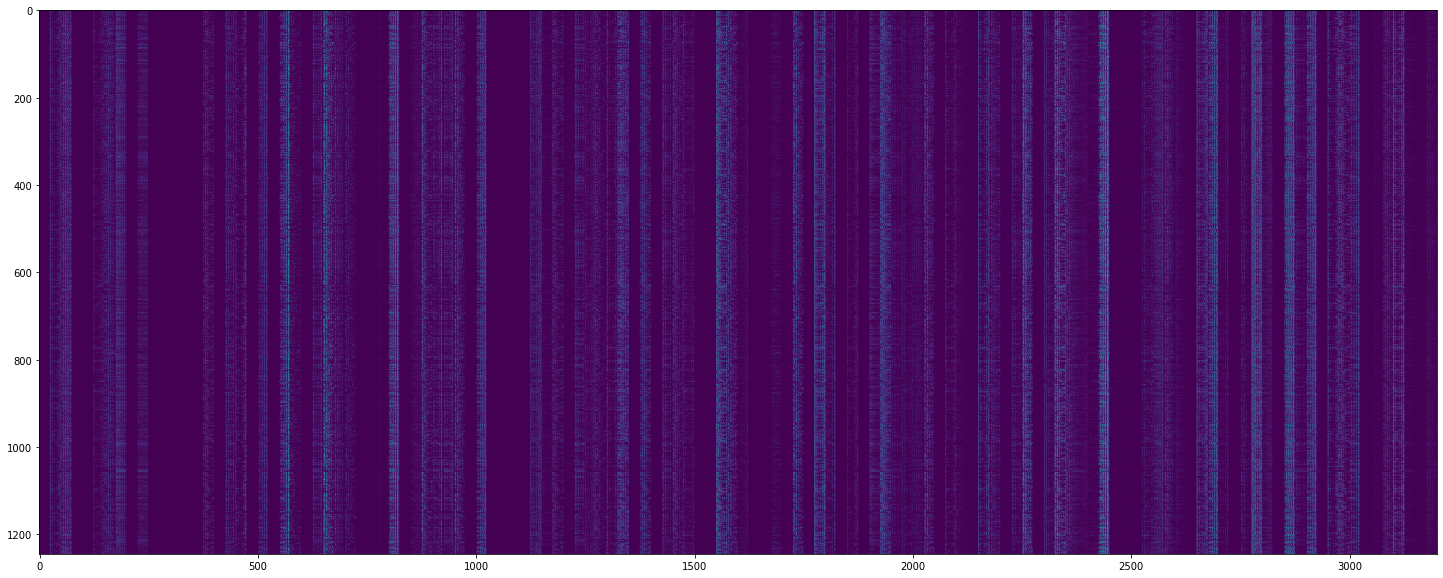

In [ ]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())